In [22]:
import os 
import getopt
import sys

import numpy as np
import h5py
import pickle
import random
import copy
import pandas as pd
import math 

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda, concatenate, Bidirectional, Dense, Dropout, Flatten, Conv1D,BatchNormalization,  MaxPooling1D, Bidirectional, GRU, TimeDistributed
import tensorflow as tf
from tensorflow import keras


np.random.seed(1337) # for reproducibility
vocab = ["A", "G", "C", "T"]
indices = tf.range(len(vocab), dtype = tf.int64)
table_init = tf.lookup.KeyValueTensorInitializer(vocab,indices)
table = tf.lookup.StaticVocabularyTable(table_init, 1)
defs = [0.] * 1 + [tf.constant([], dtype = "string")]

# Nadav dataset

def data_reader(file, batch_size=100, n_parse_threads = 4):
    dataset = tf.data.TextLineDataset(file).skip(1)
    dataset=dataset.map(preprocess, num_parallel_calls = n_parse_threads)
    return dataset.batch(batch_size).prefetch(1)

def preprocess(record):
    fields = tf.io.decode_csv(record, record_defaults=defs)
    chars = tf.strings.bytes_split(fields[1])
    chars_indeces = table.lookup(chars)
    X = tf.one_hot(chars_indeces, depth = len(vocab))
    Y = fields[0]
    return X,Y


In [32]:
from sklearn.model_selection import train_test_split

# Split the data in three partitions
file="/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/LibA_wide_pivot_state3.csv"
whole_data = pd.read_csv("/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/LibA_wide_pivot_state3.csv")

df_train, df_test = train_test_split(whole_data, test_size=0.2, random_state=42)
df_validation, df_test = train_test_split(df_test, test_size=0.5, random_state=42)

df_train.to_csv("/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/LibA_wide_pivot_state3_train.csv", index=False)
df_test.to_csv("/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/LibA_wide_pivot_state3_test.csv", index=False)
df_validation.to_csv("/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/LibA_wide_pivot_state3_validation.csv", index=False)


In [33]:
input_path_train = "/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/LibA_wide_pivot_state3_train.csv"
input_path_valid = "/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/LibA_wide_pivot_state3_validation.csv"
input_path_test = "/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/LibA_wide_pivot_state3_test.csv"

# Get first item of the dataset to get the shape of the input data
for element in data_reader(file):
    input_shape = element[0].shape

inputs = Input(shape=(input_shape[1],input_shape[2]), name="inputs")
layer = Conv1D(250, kernel_size=7, strides=1, activation='relu', name="conv1")(inputs)  # 250 7 relu
layer = Dropout(0.3)(layer)
layer = BatchNormalization()(layer)
layer = Conv1D(250, 8, strides=1, activation='softmax', name="conv2")(layer)  # 250 8 softmax
layer = BatchNormalization()(layer)
layer = MaxPooling1D(pool_size=2, strides=None, name="maxpool1")(layer)
layer = Dropout(0.3)(layer)
layer = Conv1D(250, 3, strides=1, activation='softmax', name="conv3")(layer)  # 250 3 softmax
layer = BatchNormalization()(layer)
layer = Dropout(0.3)(layer)
layer = Conv1D(100, 2, strides=1, activation='softmax', name="conv4")(layer)  # 100 3 softmax
layer = BatchNormalization()(layer)
layer = MaxPooling1D(pool_size=1, strides=None, name="maxpool2")(layer)
layer = Dropout(0.3)(layer)
layer = Flatten()(layer)
layer = Dense(300, activation='sigmoid')(layer)  # 300
layer = Dropout(0.3)(layer)
layer = Dense(200, activation='sigmoid')(layer)  # 300
predictions = Dense(1, activation='linear')(layer)

model = Model(inputs=inputs, outputs=predictions)
model.summary()

model.compile(optimizer="adam",
              loss="mean_squared_error",
              metrics=["mse", "mae", "mape"],
              )

history=model.fit(data_reader(input_path_train, batch_size=1024),
                        epochs=20,
                        validation_data=data_reader(file,batch_size=100),
                        callbacks=None,
                        verbose=1)

predicted = model.predict(data_reader(input_path_test,
                                            batch_size=100))

test_data = data_reader(input_path_test,batch_size=100)
test_tensor = X = np.empty(shape=[0,1])
for batch in test_data:
    test_tensor = np.append(test_tensor, batch[1])

import math
def pearson_correlation(x, y):
    n = len(x)
    # Calculate the mean of x and y
    mean_x = sum(x) / n
    mean_y = sum(y) / n
    
    # Calculate the numerator and denominators of the correlation coefficient
    numerator = sum((xi - mean_x) * (yi - mean_y) for xi, yi in zip(x, y))
    denominator_x = math.sqrt(sum((xi - mean_x) ** 2 for xi in x))
    denominator_y = math.sqrt(sum((yi - mean_y) ** 2 for yi in y))
    
    # Calculate the correlation coefficient
    correlation = numerator / (denominator_x * denominator_y)
    return correlation
    
corr_coefficient = pearson_correlation(predicted.flatten(), test_tensor)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 262, 4)]          0         
                                                                 
 conv1 (Conv1D)              (None, 256, 250)          7250      
                                                                 
 dropout_25 (Dropout)        (None, 256, 250)          0         
                                                                 
 batch_normalization_20 (Ba  (None, 256, 250)          1000      
 tchNormalization)                                               
                                                                 
 conv2 (Conv1D)              (None, 249, 250)          500250    
                                                                 
 batch_normalization_21 (Ba  (None, 249, 250)          1000      
 tchNormalization)                                         

2023-10-16 14:02:49.904138: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6726460305429972793
2023-10-16 14:02:49.904233: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 553158323905315772


7/7 [==============================] - 2s 241ms/step - loss: 0.0933 - mse: 0.0933 - mae: 0.2567 - mape: 49036.4766 - val_loss: 0.0566 - val_mse: 0.0566 - val_mae: 0.1958 - val_mape: 18938.7520
Epoch 3/20
7/7 [==============================] - 2s 239ms/step - loss: 0.0576 - mse: 0.0576 - mae: 0.1875 - mape: 13385.5723 - val_loss: 0.0328 - val_mse: 0.0328 - val_mae: 0.1533 - val_mape: 21369.5801
Epoch 4/20
7/7 [==============================] - 2s 226ms/step - loss: 0.0405 - mse: 0.0405 - mae: 0.1597 - mape: 44409.5234 - val_loss: 0.0386 - val_mse: 0.0386 - val_mae: 0.1480 - val_mape: 11794.4434
Epoch 5/20
7/7 [==============================] - 2s 236ms/step - loss: 0.0336 - mse: 0.0336 - mae: 0.1417 - mape: 14764.5156 - val_loss: 0.0206 - val_mse: 0.0206 - val_mae: 0.1073 - val_mape: 10528.7275
Epoch 6/20
7/7 [==============================] - 2s 236ms/step - loss: 0.0285 - mse: 0.0285 - mae: 0.1302 - mape: 12499.4150 - val_loss: 0.0231 - val_mse: 0.0231 - val_mae: 0.1025 - val_mape: 15

In [27]:
print("Correlation: "+str(corr_coefficient))
print("Test Data : \n"+str(test_tensor[:10]))
print("Predictions :\n" +str(predicted[:10]))

Correlation: 0.43623343891527105
Test Data : 
[ 0.07387622 -0.02064122 -0.01574964 -0.14560808  0.02438584 -0.00905595
  0.02555897 -0.01925485  0.1474456   0.00337036]
Predictions :
[[0.04586424]
 [0.04586142]
 [0.04586267]
 [0.0458631 ]
 [0.04586616]
 [0.04586191]
 [0.04586439]
 [0.0458629 ]
 [0.04586322]
 [0.04586347]]


In [40]:
df_test["prediction"] = predicted
df_test.to_csv("/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/LibA_wide_pivot_state3_test_predicte.csv", index=False)


In [28]:
from sklearn.model_selection import train_test_split
# Split the data in three partitions
file="/home/felix/cluster/fpacheco/Data/Nadav_lab/K562/mean_with_sequence_ENCFF616IAQ.csv"
whole_data = pd.read_csv(file)

df_train, df_test = train_test_split(whole_data, test_size=0.2, random_state=42)
df_validation, df_test = train_test_split(df_test, test_size=0.5, random_state=42)

df_train[["meanVal", "sequence"]].to_csv("/home/felix/cluster/fpacheco/Data/Nadav_lab/K562/mean_with_sequence_ENCFF616IAQ_train.csv", index=False)
df_test[["meanVal", "sequence"]].to_csv("/home/felix/cluster/fpacheco/Data/Nadav_lab/K562/mean_with_sequence_ENCFF616IAQ_test.csv", index=False)
df_validation[["meanVal", "sequence"]].to_csv("/home/felix/cluster/fpacheco/Data/Nadav_lab/K562/mean_with_sequence_ENCFF616IAQ_validation.csv", index=False)

In [29]:

input_path_train = "/home/felix/cluster/fpacheco/Data/Nadav_lab/K562/mean_with_sequence_ENCFF616IAQ_train.csv"
input_path_test = "/home/felix/cluster/fpacheco/Data/Nadav_lab/K562/mean_with_sequence_ENCFF616IAQ_test.csv"
input_path_valid = "/home/felix/cluster/fpacheco/Data/Nadav_lab/K562/mean_with_sequence_ENCFF616IAQ_validation.csv"

# Get first item of the dataset to get the shape of the input data
for element in data_reader(input_path_train):
    input_shape = element[0].shape

inputs = Input(shape=(input_shape[1],input_shape[2]), name="inputs")
layer = Conv1D(250, kernel_size=7, strides=1, activation='relu', name="conv1")(inputs)  # 250 7 relu
layer = Dropout(0.5)(layer)
layer = BatchNormalization()(layer)
layer = Conv1D(250, 8, strides=1, activation='softmax', name="conv2")(layer)  # 250 8 softmax
layer = BatchNormalization()(layer)
layer = MaxPooling1D(pool_size=2, strides=None, name="maxpool1")(layer)
layer = Dropout(0.5)(layer)
layer = Conv1D(250, 3, strides=1, activation='softmax', name="conv3")(layer)  # 250 3 softmax
layer = BatchNormalization()(layer)
layer = Dropout(0.5)(layer)
layer = Conv1D(100, 2, strides=1, activation='softmax', name="conv4")(layer)  # 100 3 softmax
layer = BatchNormalization()(layer)
layer = MaxPooling1D(pool_size=1, strides=None, name="maxpool2")(layer)
layer = Dropout(0.5)(layer)
layer = Flatten()(layer)
layer = Dense(300, activation='sigmoid')(layer)  # 300
layer = Dropout(0.5)(layer)
layer = Dense(200, activation='sigmoid')(layer)  # 300
predictions = Dense(1, activation='linear')(layer)

model = Model(inputs=inputs, outputs=predictions)
model.summary()

model.compile(optimizer="adam",
              loss="mean_squared_error",
              metrics=["mse", "mae", "mape"],
              )

history=model.fit(data_reader(input_path_train, batch_size=1024),
                        epochs=15,
                        validation_data=data_reader(input_path_valid,batch_size=100),
                        callbacks=None,
                        verbose=1)

predicted = model.predict(data_reader(input_path_test,
                                            batch_size=100))

test_data = data_reader(input_path_test,batch_size=100)
test_tensor = X = np.empty(shape=[0,1])
for batch in test_data:
    test_tensor = np.append(test_tensor, batch[1])

import math
def pearson_correlation(x, y):
    n = len(x)
    # Calculate the mean of x and y
    mean_x = sum(x) / n
    mean_y = sum(y) / n
    
    # Calculate the numerator and denominators of the correlation coefficient
    numerator = sum((xi - mean_x) * (yi - mean_y) for xi, yi in zip(x, y))
    denominator_x = math.sqrt(sum((xi - mean_x) ** 2 for xi in x))
    denominator_y = math.sqrt(sum((yi - mean_y) ** 2 for yi in y))
    
    # Calculate the correlation coefficient
    correlation = numerator / (denominator_x * denominator_y)
    return correlation
    
corr_coefficient = pearson_correlation(predicted.flatten(), test_tensor)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 200, 4)]          0         
                                                                 
 conv1 (Conv1D)              (None, 194, 250)          7250      
                                                                 
 dropout_20 (Dropout)        (None, 194, 250)          0         
                                                                 
 batch_normalization_16 (Ba  (None, 194, 250)          1000      
 tchNormalization)                                               
                                                                 
 conv2 (Conv1D)              (None, 187, 250)          500250    
                                                                 
 batch_normalization_17 (Ba  (None, 187, 250)          1000      
 tchNormalization)                                         

2023-10-16 13:24:18.672193: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6726460305429972793
2023-10-16 13:24:18.672272: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 553158323905315772


178/178 [==============================] - 20s 97ms/step - loss: 0.2299 - mse: 0.2299 - mae: 0.3685 - mape: 16853.4922 - val_loss: 0.2727 - val_mse: 0.2727 - val_mae: 0.3933 - val_mape: 1382.4210
Epoch 2/15
178/178 [==============================] - 17s 96ms/step - loss: 0.1743 - mse: 0.1743 - mae: 0.3196 - mape: 18018.6973 - val_loss: 0.2746 - val_mse: 0.2746 - val_mae: 0.3924 - val_mape: 734.6246
Epoch 3/15
178/178 [==============================] - 17s 96ms/step - loss: 0.1621 - mse: 0.1621 - mae: 0.3076 - mape: 15719.6982 - val_loss: 0.2665 - val_mse: 0.2665 - val_mae: 0.3867 - val_mape: 550.0858
Epoch 4/15
178/178 [==============================] - 17s 96ms/step - loss: 0.1535 - mse: 0.1535 - mae: 0.2993 - mape: 18624.5156 - val_loss: 0.2015 - val_mse: 0.2015 - val_mae: 0.3344 - val_mape: 2385.3145
Epoch 5/15
178/178 [==============================] - 17s 97ms/step - loss: 0.1489 - mse: 0.1489 - mae: 0.2950 - mape: 11971.6855 - val_loss: 0.1598 - val_mse: 0.1598 - val_mae: 0.2941 

In [30]:
print("Correlation: "+str(corr_coefficient))
print("Test Data : \n"+str(test_tensor[:10]))
print("Predictions :\n" +str(predicted[:10]))

Correlation: 0.741615309417504
Test Data : 
[-0.48159999 -0.29210001 -0.1759     -0.013      -0.1503     -0.83139998
  0.21950001 -0.37349999 -0.76859999 -0.4903    ]
Predictions :
[[ 0.11326885]
 [-0.35315323]
 [-0.13910185]
 [-0.08272813]
 [-0.45598155]
 [-0.58133066]
 [ 0.1547365 ]
 [-0.38562232]
 [-0.4525873 ]
 [-0.33103788]]


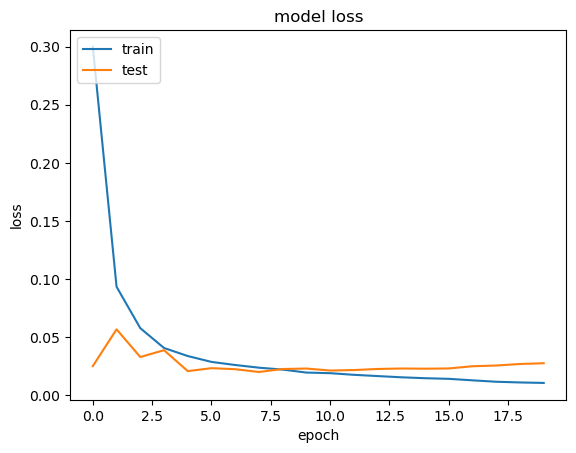

<Figure size 640x480 with 0 Axes>

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
def create_plots(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plt.clf()
    
create_plots(history)

In [21]:
#Read Data
import shap
_dataset = data_reader("/home/felix/cluster/fpacheco/Data/Nadav_lab/K562/mean_with_sequence_ENCFF616IAQ_2col_test.csv", batch_size=10000)
shuffled_dataset = _dataset.shuffle(5000)
iterator = shuffled_dataset.as_numpy_iterator()
random_sample = next(iterator)
X = random_sample[0]

rn=np.random.choice([X,  X[:,::-1,::-1]][0].shape[0], 1000, replace=False)
explainer = shap.DeepExplainer((model.inputs, model.layers[-1].output), X[rn])
explainer.shap_values(X[0:10], ranked_outputs=1)

#shap_values_top, indexes = explainer.shap_values(X, ranked_outputs=1)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


StopIteration: 

In [ ]:
#Read Data
import shap
_dataset = data_reader("/home/felix/cluster/fpacheco/Data/Nadav_lab/K562/mean_with_sequence_ENCFF616IAQ_2col_test.csv", batch_size=10000)
shuffled_dataset = _dataset.shuffle(5000)
iterator = shuffled_dataset.as_numpy_iterator()
random_sample = next(iterator)
X = random_sample[0]

In [ ]:
print(X.shape)
rn=np.random.choice([X,  X[:,::-1,::-1]][0].shape[0], 1000, replace=False)
X[rn].shape

In [ ]:
rn=np.random.choice([X,  X[:,::-1,::-1]][0].shape[0], 200, replace=False)
rn

In [ ]:
def one_hot_to_dna_sequence(one_hot_sequence, vocab):
    """
    Convert a one-hot-encoded DNA sequence back to a DNA sequence using the provided vocabulary.
    Args:
    - one_hot_sequence: A tensor containing the one-hot-encoded DNA sequence.
    - vocab: A list of vocabulary characters (e.g., ["A", "G", "C", "T"]).

    Returns:
    - dna_sequence: A tensor containing the decoded DNA sequence.
    """
    # Get the index of the maximum value along the one-hot encoding axis
    decoded_indices = tf.argmax(one_hot_sequence, axis=-1)

    # Use the indices to map back to DNA characters
    dna_sequence = tf.gather(vocab, decoded_indices)

    return dna_sequence

In [51]:
whole_data

,State_3E,seq
0,0.189065,AGGACCGGATCAACTAAAAAAATTTTCCACGCTTTCTGCTTAGCAC...
1,0.075877,AGGACCGGATCAACTAAAAAAGTGGGGCTTATAGTGTCCCTACCAG...
2,-0.016712,AGGACCGGATCAACTAAAAAGAGCCCGAGTAGTGTTCGTCTGTCGA...
3,0.083258,AGGACCGGATCAACTAAAAATAACCGACCGCCAGGTGATCTTCCCT...
4,-0.010862,AGGACCGGATCAACTAAAAATACCAGCTCAACGCATCAGGCCCCGA...
...,...,...
8473,0.232320,AGGACCGGATCAACTTTTTTCTCCTCCGATACTGTACGTTACTCTT...
8474,-0.034994,AGGACCGGATCAACTTTTTTGATGCGTAAAGTCTAGAACGCTGGAA...
8475,-0.003203,AGGACCGGATCAACTTTTTTGCTAACATGCCAAATGCGGTAACAGA...
8476,0.356185,AGGACCGGATCAACTTTTTTTATTTCAGTTTGGTATTCCGAACGAC...


In [85]:
# CROSS VALIDATION
from sklearn.model_selection import train_test_split, KFold

# Split the data in three partitions
file="/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/LibA_wide_pivot_state3.csv"
whole_data = pd.read_csv("/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/LibA_wide_pivot_state3.csv")

kf = KFold(n_splits = 10, shuffle = True, random_state = 2008)
result = next(kf.split(whole_data), None)

o=1
for i in kf.split(whole_data):
    train = whole_data.iloc[i[0]]
    test =  whole_data.iloc[i[1]]
    
    train, validation = train_test_split(whole_data, test_size=0.10, random_state=42)
    
    train.to_csv("/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/CV"+str(o)+"_LibA_wide_pivot_state3_train.csv", index=False)
    test.to_csv("/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/CV"+str(o)+"_LibA_wide_pivot_state3_test.csv", index=False)
    validation.to_csv("/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/CV"+str(o)+"_LibA_wide_pivot_state3_validation.csv", index=False)
    o+=1
        

In [87]:
df_test_overall  = pd.DataFrame(columns=['State_3E', "seq", "prediction"])
print(df_test_overall)
corr_list = []

for i in range(1,10):
    
    input_path_train = "/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/CV"+str(i)+"_LibA_wide_pivot_state3_train.csv"
    input_path_valid = "/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/CV"+str(i)+"_LibA_wide_pivot_state3_validation.csv"
    input_path_test = "/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/CV"+str(i)+"_LibA_wide_pivot_state3_test.csv"
    df_test = pd.read_csv(input_path_test)

    # Get first item of the dataset to get the shape of the input data
    for element in data_reader(file):
        input_shape = element[0].shape

    inputs = Input(shape=(input_shape[1],input_shape[2]), name="inputs")
    layer = Conv1D(250, kernel_size=7, strides=1, activation='relu', name="conv1")(inputs)  # 250 7 relu
    layer = Dropout(0.3)(layer)
    layer = BatchNormalization()(layer)
    layer = Conv1D(250, 8, strides=1, activation='softmax', name="conv2")(layer)  # 250 8 softmax
    layer = BatchNormalization()(layer)
    layer = MaxPooling1D(pool_size=2, strides=None, name="maxpool1")(layer)
    layer = Dropout(0.3)(layer)
    layer = Conv1D(250, 3, strides=1, activation='softmax', name="conv3")(layer)  # 250 3 softmax
    layer = BatchNormalization()(layer)
    layer = Dropout(0.3)(layer)
    layer = Conv1D(100, 2, strides=1, activation='softmax', name="conv4")(layer)  # 100 3 softmax
    layer = BatchNormalization()(layer)
    layer = MaxPooling1D(pool_size=1, strides=None, name="maxpool2")(layer)
    layer = Dropout(0.3)(layer)
    layer = Flatten()(layer)
    layer = Dense(300, activation='sigmoid')(layer)  # 300
    layer = Dropout(0.3)(layer)
    layer = Dense(200, activation='sigmoid')(layer)  # 300
    predictions = Dense(1, activation='linear')(layer)

    model = Model(inputs=inputs, outputs=predictions)
    model.summary()

    model.compile(optimizer="adam",
                loss="mean_squared_error",
                metrics=["mse", "mae", "mape"],
                )

    history=model.fit(data_reader(input_path_train, batch_size=1024),
                            epochs=20,
                            validation_data=data_reader(file,batch_size=100),
                            callbacks=None,
                            verbose=1)

    predicted = model.predict(data_reader(input_path_test,
                                                batch_size=100))

    test_data = data_reader(input_path_test,batch_size=100)
    test_tensor = X = np.empty(shape=[0,1])
    for batch in test_data:
        test_tensor = np.append(test_tensor, batch[1])

    df_test["prediction"] = predicted
    df_test_overall = df_test_overall.append(df_test, ignore_index=True)
    
    def pearson_correlation(x, y):
        n = len(x)
        # Calculate the mean of x and y
        mean_x = sum(x) / n
        mean_y = sum(y) / n
        
        # Calculate the numerator and denominators of the correlation coefficient
        numerator = sum((xi - mean_x) * (yi - mean_y) for xi, yi in zip(x, y))
        denominator_x = math.sqrt(sum((xi - mean_x) ** 2 for xi in x))
        denominator_y = math.sqrt(sum((yi - mean_y) ** 2 for yi in y))
        
        # Calculate the correlation coefficient
        correlation = numerator / (denominator_x * denominator_y)
        return correlation
        
    corr_coefficient = pearson_correlation(predicted.flatten(), test_tensor)
    corr_list.append(corr_coefficient)

df_test_overall.to_csv("/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/LibA_wide_pivot_state3_test_predicted_cv10fold.csv", index=False)

Empty DataFrame
Columns: [State_3E, seq, prediction]
Index: []
Model: "model_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 262, 4)]          0         
                                                                 
 conv1 (Conv1D)              (None, 256, 250)          7250      
                                                                 
 dropout_165 (Dropout)       (None, 256, 250)          0         
                                                                 
 batch_normalization_132 (B  (None, 256, 250)          1000      
 atchNormalization)                                              
                                                                 
 conv2 (Conv1D)              (None, 249, 250)          500250    
                                                                 
 batch_normalization_133 (B  (None, 249, 250)          1000  

2023-10-16 16:05:37.442983: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6726460305429972793
2023-10-16 16:05:37.443076: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 553158323905315772


8/8 [==============================] - 2s 228ms/step - loss: 0.0612 - mse: 0.0612 - mae: 0.1971 - mape: 11188.1738 - val_loss: 0.0208 - val_mse: 0.0208 - val_mae: 0.1085 - val_mape: 10966.0527
Epoch 3/20
8/8 [==============================] - 2s 222ms/step - loss: 0.0383 - mse: 0.0383 - mae: 0.1532 - mape: 9272.3408 - val_loss: 0.0273 - val_mse: 0.0273 - val_mae: 0.1142 - val_mape: 5253.1997
Epoch 4/20
8/8 [==============================] - 2s 223ms/step - loss: 0.0322 - mse: 0.0322 - mae: 0.1392 - mape: 2738.0203 - val_loss: 0.0250 - val_mse: 0.0250 - val_mae: 0.1076 - val_mape: 3408.8870
Epoch 5/20
8/8 [==============================] - 2s 220ms/step - loss: 0.0289 - mse: 0.0289 - mae: 0.1320 - mape: 14265.9707 - val_loss: 0.0204 - val_mse: 0.0204 - val_mae: 0.0971 - val_mape: 2736.1873
Epoch 6/20
8/8 [==============================] - 2s 213ms/step - loss: 0.0241 - mse: 0.0241 - mae: 0.1201 - mape: 10216.8916 - val_loss: 0.0198 - val_mse: 0.0198 - val_mae: 0.0972 - val_mape: 4588.01

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Model: "model_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 262, 4)]          0         
                                                                 
 conv1 (Conv1D)              (None, 256, 250)          7250      
                                                                 
 dropout_170 (Dropout)       (None, 256, 250)          0         
                                                                 
 batch_normalization_136 (B  (None, 256, 250)          1000      
 atchNormalization)                                              
                                                                 
 conv2 (Conv1D)              (None, 249, 250)          500250    
                                                                 
 batch_normalization_137 (B  (None, 249, 250)          1000      
 atchNormalization)                                       

2023-10-16 16:06:16.524906: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6726460305429972793


8/8 [==============================] - 5s 263ms/step - loss: 0.1457 - mse: 0.1457 - mae: 0.3205 - mape: 6115.9741 - val_loss: 0.0430 - val_mse: 0.0430 - val_mae: 0.1605 - val_mape: 13770.3867
Epoch 2/20


2023-10-16 16:06:17.558934: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6726460305429972793
2023-10-16 16:06:17.559029: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 553158323905315772


8/8 [==============================] - 2s 220ms/step - loss: 0.0508 - mse: 0.0508 - mae: 0.1809 - mape: 5351.1328 - val_loss: 0.0410 - val_mse: 0.0410 - val_mae: 0.1549 - val_mape: 12906.8838
Epoch 3/20
8/8 [==============================] - 2s 213ms/step - loss: 0.0440 - mse: 0.0440 - mae: 0.1637 - mape: 8331.1270 - val_loss: 0.0226 - val_mse: 0.0226 - val_mae: 0.1170 - val_mape: 13537.3564
Epoch 4/20
8/8 [==============================] - 2s 222ms/step - loss: 0.0302 - mse: 0.0302 - mae: 0.1327 - mape: 14819.7207 - val_loss: 0.0244 - val_mse: 0.0244 - val_mae: 0.1243 - val_mape: 15397.9629
Epoch 5/20
8/8 [==============================] - 2s 211ms/step - loss: 0.0265 - mse: 0.0265 - mae: 0.1252 - mape: 22770.1348 - val_loss: 0.0199 - val_mse: 0.0199 - val_mae: 0.1024 - val_mape: 8526.3906
Epoch 6/20
8/8 [==============================] - 2s 222ms/step - loss: 0.0217 - mse: 0.0217 - mae: 0.1135 - mape: 29116.3867 - val_loss: 0.0203 - val_mse: 0.0203 - val_mae: 0.0970 - val_mape: 2934.

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Model: "model_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 262, 4)]          0         
                                                                 
 conv1 (Conv1D)              (None, 256, 250)          7250      
                                                                 
 dropout_175 (Dropout)       (None, 256, 250)          0         
                                                                 
 batch_normalization_140 (B  (None, 256, 250)          1000      
 atchNormalization)                                              
                                                                 
 conv2 (Conv1D)              (None, 249, 250)          500250    
                                                                 
 batch_normalization_141 (B  (None, 249, 250)          1000      
 atchNormalization)                                       

2023-10-16 16:07:32.181079: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6726460305429972793
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Model: "model_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 262, 4)]          0         
                                                                 
 conv1 (Conv1D)              (None, 256, 250)          7250      
                                                                 
 dropout_180 (Dropout)       (None, 256, 250)          0         
                                                                 
 batch_normalization_144 (B  (None, 256, 250)          1000      
 atchNormalization)                                              
                                                                 
 conv2 (Conv1D)              (None, 249, 250)          500250    
                                                                 
 batch_normalization_145 (B  (None, 249, 250)          1000      
 atchNormalization)                                       

2023-10-16 16:07:37.005051: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 553158323905315772


8/8 [==============================] - 5s 264ms/step - loss: 0.1124 - mse: 0.1124 - mae: 0.2814 - mape: 59497.4375 - val_loss: 0.0230 - val_mse: 0.0230 - val_mae: 0.1186 - val_mape: 13956.7666
Epoch 2/20


2023-10-16 16:07:38.040888: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6726460305429972793
2023-10-16 16:07:38.040970: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 553158323905315772


8/8 [==============================] - 2s 224ms/step - loss: 0.0494 - mse: 0.0494 - mae: 0.1766 - mape: 23962.1602 - val_loss: 0.0268 - val_mse: 0.0268 - val_mae: 0.1126 - val_mape: 4833.4370
Epoch 3/20
8/8 [==============================] - 2s 224ms/step - loss: 0.0371 - mse: 0.0371 - mae: 0.1498 - mape: 17208.3516 - val_loss: 0.0332 - val_mse: 0.0332 - val_mae: 0.1320 - val_mape: 9017.2266
Epoch 4/20
8/8 [==============================] - 2s 222ms/step - loss: 0.0322 - mse: 0.0322 - mae: 0.1388 - mape: 3610.1614 - val_loss: 0.0261 - val_mse: 0.0261 - val_mae: 0.1108 - val_mape: 4334.5454
Epoch 5/20
8/8 [==============================] - 2s 200ms/step - loss: 0.0285 - mse: 0.0285 - mae: 0.1313 - mape: 15606.0654 - val_loss: 0.0224 - val_mse: 0.0224 - val_mae: 0.1008 - val_mape: 754.4680
Epoch 6/20
8/8 [==============================] - 2s 220ms/step - loss: 0.0252 - mse: 0.0252 - mae: 0.1239 - mape: 12859.1377 - val_loss: 0.0224 - val_mse: 0.0224 - val_mae: 0.1007 - val_mape: 696.6161

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Model: "model_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 262, 4)]          0         
                                                                 
 conv1 (Conv1D)              (None, 256, 250)          7250      
                                                                 
 dropout_185 (Dropout)       (None, 256, 250)          0         
                                                                 
 batch_normalization_148 (B  (None, 256, 250)          1000      
 atchNormalization)                                              
                                                                 
 conv2 (Conv1D)              (None, 249, 250)          500250    
                                                                 
 batch_normalization_149 (B  (None, 249, 250)          1000      
 atchNormalization)                                       

2023-10-16 16:08:17.017096: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6726460305429972793
2023-10-16 16:08:17.017165: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 553158323905315772


8/8 [==============================] - 5s 254ms/step - loss: 0.1368 - mse: 0.1368 - mae: 0.3094 - mape: 6771.1895 - val_loss: 0.0400 - val_mse: 0.0400 - val_mae: 0.1740 - val_mape: 25053.4316
Epoch 2/20
8/8 [==============================] - 2s 194ms/step - loss: 0.0484 - mse: 0.0484 - mae: 0.1702 - mape: 10081.4492 - val_loss: 0.0342 - val_mse: 0.0342 - val_mae: 0.1575 - val_mape: 22147.8066
Epoch 3/20
8/8 [==============================] - 2s 195ms/step - loss: 0.0390 - mse: 0.0390 - mae: 0.1546 - mape: 26704.9746 - val_loss: 0.0250 - val_mse: 0.0250 - val_mae: 0.1075 - val_mape: 3366.3298
Epoch 4/20
8/8 [==============================] - 2s 215ms/step - loss: 0.0293 - mse: 0.0293 - mae: 0.1335 - mape: 9726.6709 - val_loss: 0.0282 - val_mse: 0.0282 - val_mae: 0.1168 - val_mape: 5876.2065
Epoch 5/20
8/8 [==============================] - 2s 214ms/step - loss: 0.0258 - mse: 0.0258 - mae: 0.1234 - mape: 20137.7715 - val_loss: 0.0202 - val_mse: 0.0202 - val_mae: 0.0970 - val_mape: 3114.4

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Model: "model_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 262, 4)]          0         
                                                                 
 conv1 (Conv1D)              (None, 256, 250)          7250      
                                                                 
 dropout_190 (Dropout)       (None, 256, 250)          0         
                                                                 
 batch_normalization_152 (B  (None, 256, 250)          1000      
 atchNormalization)                                              
                                                                 
 conv2 (Conv1D)              (None, 249, 250)          500250    
                                                                 
 batch_normalization_153 (B  (None, 249, 250)          1000      
 atchNormalization)                                       

2023-10-16 16:09:30.161307: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6726460305429972793
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Model: "model_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 262, 4)]          0         
                                                                 
 conv1 (Conv1D)              (None, 256, 250)          7250      
                                                                 
 dropout_195 (Dropout)       (None, 256, 250)          0         
                                                                 
 batch_normalization_156 (B  (None, 256, 250)          1000      
 atchNormalization)                                              
                                                                 
 conv2 (Conv1D)              (None, 249, 250)          500250    
                                                                 
 batch_normalization_157 (B  (None, 249, 250)          1000      
 atchNormalization)                                       

2023-10-16 16:10:10.700009: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6726460305429972793
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Model: "model_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 262, 4)]          0         
                                                                 
 conv1 (Conv1D)              (None, 256, 250)          7250      
                                                                 
 dropout_200 (Dropout)       (None, 256, 250)          0         
                                                                 
 batch_normalization_160 (B  (None, 256, 250)          1000      
 atchNormalization)                                              
                                                                 
 conv2 (Conv1D)              (None, 249, 250)          500250    
                                                                 
 batch_normalization_161 (B  (None, 249, 250)          1000      
 atchNormalization)                                       

2023-10-16 16:10:16.502477: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6726460305429972793
2023-10-16 16:10:16.502548: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 553158323905315772


8/8 [==============================] - 2s 210ms/step - loss: 0.1475 - mse: 0.1475 - mae: 0.3351 - mape: 14374.2295 - val_loss: 0.0342 - val_mse: 0.0342 - val_mae: 0.1577 - val_mape: 22184.3672
Epoch 3/20
8/8 [==============================] - 2s 212ms/step - loss: 0.0607 - mse: 0.0607 - mae: 0.1924 - mape: 19806.7461 - val_loss: 0.0259 - val_mse: 0.0259 - val_mae: 0.1303 - val_mape: 16759.0566
Epoch 4/20
8/8 [==============================] - 2s 201ms/step - loss: 0.0416 - mse: 0.0416 - mae: 0.1628 - mape: 31514.9863 - val_loss: 0.0344 - val_mse: 0.0344 - val_mae: 0.1355 - val_mape: 9651.3604
Epoch 5/20
8/8 [==============================] - 2s 200ms/step - loss: 0.0335 - mse: 0.0335 - mae: 0.1419 - mape: 4609.0493 - val_loss: 0.0206 - val_mse: 0.0206 - val_mae: 0.1070 - val_mape: 10446.7266
Epoch 6/20
8/8 [==============================] - 2s 204ms/step - loss: 0.0267 - mse: 0.0267 - mae: 0.1264 - mape: 22599.0488 - val_loss: 0.0211 - val_mse: 0.0211 - val_mae: 0.0982 - val_mape: 1238

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Model: "model_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 262, 4)]          0         
                                                                 
 conv1 (Conv1D)              (None, 256, 250)          7250      
                                                                 
 dropout_205 (Dropout)       (None, 256, 250)          0         
                                                                 
 batch_normalization_164 (B  (None, 256, 250)          1000      
 atchNormalization)                                              
                                                                 
 conv2 (Conv1D)              (None, 249, 250)          500250    
                                                                 
 batch_normalization_165 (B  (None, 249, 250)          1000      
 atchNormalization)                                       

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [88]:
df_test_overall.to_csv("/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/LibA_wide_pivot_state3_test_predicted_cv10fold.csv", index=False)
df_test_overall

,State_3E,seq,prediction
0,-0.007714,AGGACCGGATCAACTAAACAACTCAAACAAGGGCTAATATAACCCA...,0.026140
1,0.137953,AGGACCGGATCAACTAAACACTAGTCATACTTAAAAATTGCAAGGA...,0.026140
2,-0.048706,AGGACCGGATCAACTAAACAGGTTCTGACGTATGCTCCTCTATGGA...,0.026140
3,-0.052804,AGGACCGGATCAACTAAACCCGAGCCTGCCTAGCCCTAGCTTCTCT...,0.026140
4,0.213652,AGGACCGGATCAACTAAACGGAGCAGAGTTAGTGTCAGGTCAAAAA...,0.026140
...,...,...,...
7626,-0.069795,AGGACCGGATCAACTTTTGTCTTACATAGCTGGAACGACGAACGCT...,-0.098052
7627,-0.027438,AGGACCGGATCAACTTTTGTGGCTGACTCTATATTATCGAACCCCC...,-0.098050
7628,0.209585,AGGACCGGATCAACTTTTTCAGTGAAAGATCACCGCGGGATCTCAC...,-0.098048
7629,-0.153473,AGGACCGGATCAACTTTTTTAGCTTCGGAATGGATAAAACGAGCAG...,-0.098052


In [89]:
corr_list

[0.5986894757825919,
 0.5827273730261453,
 0.6064971019630407,
 0.6537739882082283,
 0.6465771167565411,
 0.5416654948282249,
 0.6103707614242305,
 0.49440679500910495,
 0.6672157842296925]